# Udacity Project - Sydney AirBNB data

### In this project, we'll use the Sydney AirBNB dataset to take a look at the following 3 questions:
- What are the busiest times of the year to visit Sydney? By how much do prices spike?
- Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Sydney?
- Can you describe the vibe of each Sydney neighborhood using listing descriptions?

Let's import some libraries first

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

The AirBNB dataset comes in 3 parts, we'll import and take a look at these

In [2]:
# 3 datasets in CSV format - listings, reviews, and calendar

listings = pd.read_csv("./listings.csv")
reviews = pd.read_csv("./reviews.csv")
calendar = pd.read_csv("./calendar.csv")

In [3]:
# look at the shape of the data
print(listings.shape)
print(reviews.shape)
print(calendar.shape)

(38080, 106)
(541665, 6)
(13899581, 7)


In [4]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11156,https://www.airbnb.com/rooms/11156,20190710033517,2019-07-11,An Oasis in the City,Very central to the city which can be reached ...,Potts Pt. is a vibrant and popular inner-city...,Very central to the city which can be reached ...,none,"It is very close to everything and everywhere,...",...,f,f,moderate,f,f,1,0,1,0,1.58
1,12351,https://www.airbnb.com/rooms/12351,20190710033517,2019-07-11,Sydney City & Harbour at the door,Come stay with Vinh & Stuart (Awarded as one o...,"We're pretty relaxed hosts, and we fully appre...",Come stay with Vinh & Stuart (Awarded as one o...,none,"Pyrmont is an inner-city village of Sydney, on...",...,f,f,strict_14_with_grace_period,t,t,2,0,2,0,4.73
2,14250,https://www.airbnb.com/rooms/14250,20190710033517,2019-07-10,Manly Harbour House,"Beautifully renovated, spacious and quiet, our...",Our home is a thirty minute walk along the sea...,"Beautifully renovated, spacious and quiet, our...",none,Balgowlah Heights is one of the most prestigio...,...,f,f,strict_14_with_grace_period,f,f,2,2,0,0,0.05
3,15253,https://www.airbnb.com/rooms/15253,20190710033517,2019-07-10,Stunning Penthouse Apartment In Heart Of The City,Penthouse living in a great central location: ...,"A charming two-level, two-bedroom, two-bathroo...",Penthouse living in a great central location: ...,none,The location is really central and there is nu...,...,t,f,strict_14_with_grace_period,f,f,3,2,1,0,3.60
4,20865,https://www.airbnb.com/rooms/20865,20190710033517,2019-07-11,3 BED HOUSE + 1 BED STUDIO Balmain,Hi! We are a married professional couple with ...,HOUSE : _________ * DUCTED AIR CONDITIONING IN...,Hi! We are a married professional couple with ...,none,BALMAIN is an older inner city village / subur...,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.17


In [5]:
# 106 columns in the listings dataset - print these out to help get a better sense of the available data
listings.columns.values

array(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name',
       'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'access',
       'interaction', 'house_rules', 'thumbnail_url', 'medium_url',
       'picture_url', 'xl_picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode',
       'market', 'smart_location', 'country_code', 'country', 'latitude',
       'longitude', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bath

In [6]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,11156,19220,2009-12-05,52946,Jeff,Colleen was friendly and very helpful regardin...
1,11156,32592,2010-03-31,99382,Michael,"Great place, centrally located, easy walk to t..."
2,11156,42280,2010-05-14,105797,Marina,Colleen is very friendly and helpful. The apar...
3,11156,140942,2010-11-17,259213,Sigrid,Dear Colleen!\r\nMy friend Diemut from Germany...
4,11156,151966,2010-12-11,273389,Eduardo,"Lovely, interesting chats and very helpful giv..."


In [7]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,873636,2019-07-10,t,$60.00,$60.00,1.0,60.0
1,1329486,2019-07-10,f,$184.00,$184.00,4.0,1125.0
2,1329486,2019-07-11,f,$184.00,$184.00,4.0,1125.0
3,1329486,2019-07-12,f,$184.00,$184.00,4.0,1125.0
4,1329486,2019-07-13,f,$184.00,$184.00,4.0,1125.0


As an initial exploration - look at any missing values for each datast

In [8]:
# proportion of missing values in the listing data
missing_prop_listings = (listings.isnull().sum()/len(listings)).sort_values(ascending=False)
missing_prop_listings

host_acceptance_rate                            1.000000
jurisdiction_names                              1.000000
xl_picture_url                                  1.000000
medium_url                                      1.000000
neighbourhood_group_cleansed                    1.000000
thumbnail_url                                   1.000000
license                                         0.998372
square_feet                                     0.993829
monthly_price                                   0.946875
weekly_price                                    0.912631
notes                                           0.590678
host_response_time                              0.467673
host_response_rate                              0.467673
host_about                                      0.465546
access                                          0.423293
interaction                                     0.420273
house_rules                                     0.415966
neighborhood_overview          

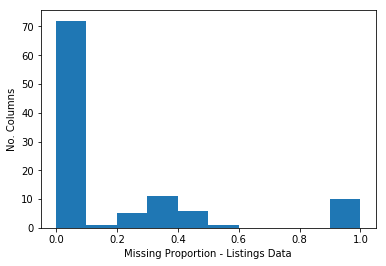

In [9]:
# plot the proportion of missing values in the listings data
plt.hist(missing_prop_listings)
plt.xlabel('Missing Proportion - Listings Data')
plt.ylabel('No. Columns')
plt.show()

In [10]:
# proportion of missing values in the calendar data
(calendar.isnull().sum()/len(calendar)).sort_values(ascending=False)

maximum_nights    0.000005
minimum_nights    0.000005
adjusted_price    0.000000
price             0.000000
available         0.000000
date              0.000000
listing_id        0.000000
dtype: float64

In [11]:
# proportion of missing values in the reviews data
(reviews.isnull().sum()/len(reviews)).sort_values(ascending=False)

comments         0.000438
reviewer_name    0.000000
reviewer_id      0.000000
date             0.000000
id               0.000000
listing_id       0.000000
dtype: float64

So, we may need to treat the missing values to complete the analysis, especially the listings data

#### 1) What are the busiest times of the year to visit Sydney? By how much do prices spike?

The calendar data lists the current and future availability of listings. As with hotels, it would seem reasonable to assume prices increase during busy times, so let's take at average prices throughout the year.

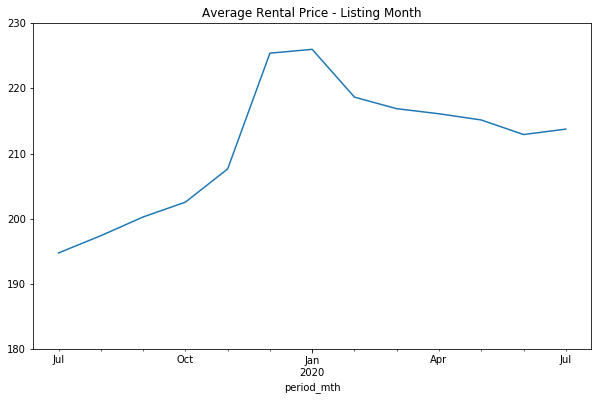

In [12]:
# convert string to numeric
calendar['price'] = calendar['price'].str.replace('$','').str.replace(',','').astype(float)

# convert string to date format
calendar['date'] = pd.to_datetime(calendar['date'])

# take start of month as reference date
calendar['period_mth'] = calendar['date'] + pd.tseries.offsets.MonthEnd(n=0) - pd.tseries.offsets.MonthBegin(n=1)

# plot average price by month
avg_price_mth = calendar.groupby(['period_mth'])['price'].mean()
avg_price_mth.plot(figsize=(10,6), ylim=(180,230), title='Average Rental Price - Listing Month')

In [13]:
print(avg_price_mth)

period_mth
2019-07-01    194.768872
2019-08-01    197.416662
2019-09-01    200.284955
2019-10-01    202.558245
2019-11-01    207.650058
2019-12-01    225.396808
2020-01-01    225.981962
2020-02-01    218.654635
2020-03-01    216.881727
2020-04-01    216.105679
2020-05-01    215.153148
2020-06-01    212.920798
2020-07-01    213.753865
Name: price, dtype: float64


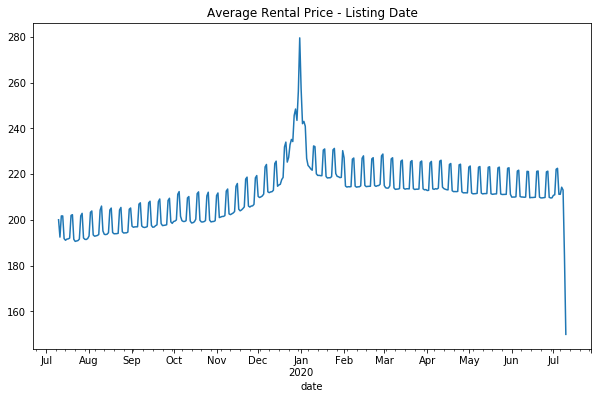

In [14]:
# take a closer look by date
avg_price_date = calendar.groupby(['date'])['price'].mean()
avg_price_date.plot(figsize=(10,6), title='Average Rental Price - Listing Date')

We can see the busiest times are the weeks before and after new years eve. December and January average prices of 225 per night, compared to 200 per night for the preceding months.

In particular, days around Christmas and New Year spike dramatically to around 280 per night.

The higher average monthly price of 215 per night post January is perhaps due to the date being several months in advance (the data is compiled in July 2019). It would be interesting to see price movements as the booking dates get nearer.

#### 2) Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Sydney?

The listings data notes contains an ID for hosts, and how long they have been a host on the platform. We can get a sense of how many new listings are being added by looking at how many new hosts are joining the platform.

For this, we'll need the "host id" and "host since" variables.

In [15]:
# drop missing values, and drop duplicates as we want just one record per host
host = listings[['host_id', 'host_since']].dropna().drop_duplicates().sort_values(by=['host_since'])

# count of hosts by join date
host['host_since'] = pd.to_datetime(host['host_since'])
host_count = host.groupby(['host_since'])['host_id'].count().reset_index() 

# cumulative count
host_count['cumulative_count'] = host_count['host_id'].cumsum()

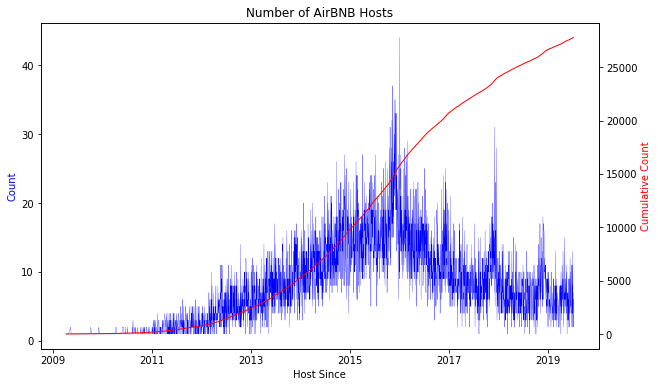

In [16]:
# plot count and cumulative count of hosts by date

fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()
ax1.plot(host_count['host_since'], host_count['host_id'], 'b-', linewidth=0.25)
ax2.plot(host_count['host_since'], host_count['cumulative_count'], 'r-', linewidth=1.0)

ax1.title.set_text('Number of AirBNB Hosts')
ax1.set_xlabel('Host Since')
ax1.set_ylabel('Count', color='b')
ax2.set_ylabel('Cumulative Count', color='r')
plt.show()

For the trend of AirBNB visitors to Sydney, we can use the number of reviews as an indicative measure.

In [17]:
# count and cumulative count of reviews
reviews['date'] = pd.to_datetime(reviews['date'])

review_count = reviews.groupby(['date'])['id'].count().reset_index() 
review_count['cumulative_count'] = review_count['id'].cumsum()

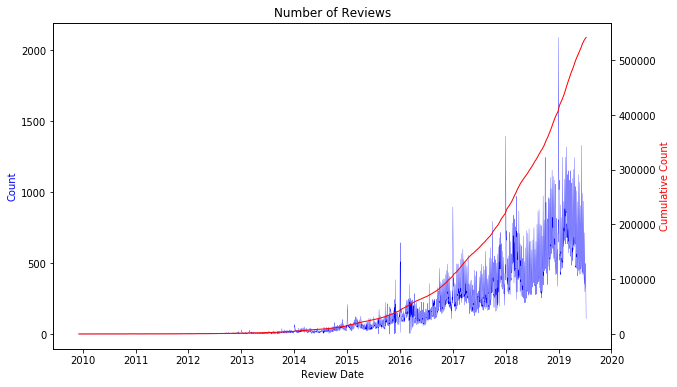

In [18]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()
ax1.plot(review_count['date'], review_count['id'], 'b-', linewidth=0.25)
ax2.plot(review_count['date'], review_count['cumulative_count'], 'r-', linewidth=1.0)

ax1.title.set_text('Number of Reviews')
ax1.set_xlabel('Review Date')
ax1.set_ylabel('Count', color='b')
ax2.set_ylabel('Cumulative Count', color='r')
plt.show()

From the above, we can see that there was a strong increase in the number of hosts on AirBNB up until 2016. Since then, the rate at which new hosts are joining has dropped off.

There has also been a continued upward trend in the number of reviews left on the site. Some of this may be due to more visitors writing reviews, but its also indicative of an increase in the number of visitors to Sydney using AirBNB.

#### 3) Can you describe the vibe of each Sydney neighborhood using listing descriptions?

For this, we'll again use the listing data. First, let's see which are top 10 neighbourhoods on the site.

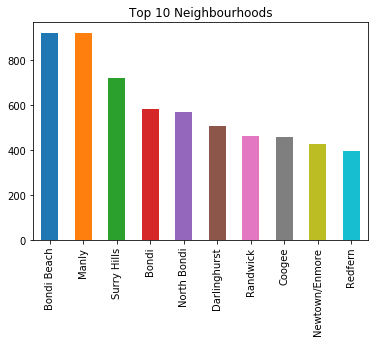

In [19]:
neighbour = listings[['neighbourhood','neighborhood_overview']]

# drop missing values and duplicate descriptions
neighbour = neighbour.replace('NaN', np.nan).dropna().drop_duplicates()

neighbour['neighbourhood'].value_counts().nlargest(10).plot(kind='bar', title='Top 10 Neighbourhoods')

In [20]:
# instantiate the tfidfvectorizer to help with the text feature extraction analysis, ignore common words
vectorizer = TfidfVectorizer(stop_words='english')

# fit against all neighbourhood descriptions
neighbour_fit = vectorizer.fit(neighbour['neighborhood_overview'])

def neighbour_desc(loc, n):
    '''
    Function to get the top n keywords for a neighbourhood

    Parameters:
    loc (str): name of the neighbourhood area
    n (int): number of top keywords to get

    Returns:
    top_n: plots a list of top n keywords for the neighbourhood

    '''
    
    select_neighbour = neighbour[neighbour['neighbourhood'] == loc]
    neighbour_transform = vectorizer.transform(select_neighbour['neighborhood_overview'])
    
    tfidf = np.asarray(neighbour_transform.mean(axis=0)).flatten()
    tfidf_list = pd.DataFrame({'word': vectorizer.get_feature_names(), 'tf-idf':tfidf})

    top_n = tfidf_list.sort_values(by='tf-idf', ascending=False)[:n]

    top_n.plot(kind='barh', x='word', title=loc)

Let's take a look at descriptions for 3 of the neighbourhoods

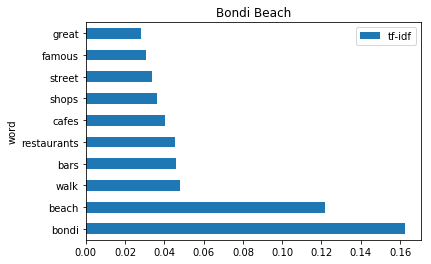

In [21]:
neighbour_desc(loc='Bondi Beach', n=10)

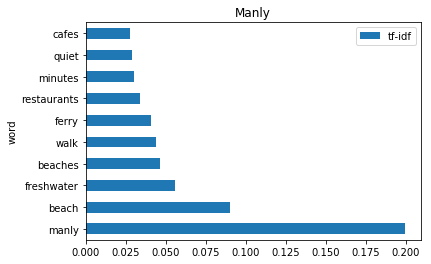

In [22]:
neighbour_desc(loc='Manly', n=10)

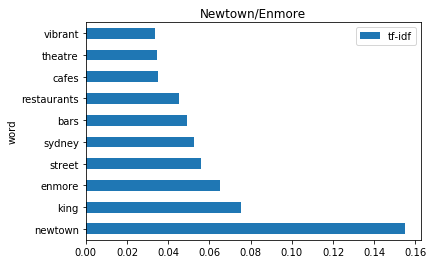

In [23]:
neighbour_desc(loc='Newtown/Enmore', n=10)

The top keywords appear to be quite accurate for the neighbourhoods:

Bondi Beach is one of the most *famous* tourist sites in Sydney. As with most popular beach locations, there are plenty of *bars*, *restaurants*, and *cafes* dotted nearby.

Manly is also a well known beach destination. *Freshwater Beach* is also a short walk away. *Ferry* services operate on Sydney Harbour, and the trip between Manly and Circular Quay is a "must do" for many visitors.

For those already familiar with Sydney - *King Street* in Newtown/Enmore is a hip and *vibrant* area for food and the arts catering to a large range of tastes. *Enmore Theatre* is a live comedy and music venue.